<a href="https://colab.research.google.com/github/Mike030668/MIPT_magistratura/blob/main/RL/DZ_4/DZ_4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

import gym
import numpy as np
import matplotlib.pyplot as plt
import random
from functools import partial
from IPython.display import clear_output
%matplotlib inline

#Обучение с подкреплением с использованием модели мира

**Задача: реализация и анализ алгоритма Dyna на детерминированной и стохастической среде, основанной на среде из первого задания.**

- Описание. Детерминированная среда:

    Реализовать табличный алгоритм Dyna на основе среды из первого задания.
    Протестировать Dyna с различным количеством шагов планирования начиная с 0 (которое соответствует обычному Q-обучению).
    Сравнить результаты в виде графиков суммарного вознаграждения и времени обучения для каждого значения шагов планирования.
    Стохастическая среда:

- Модифицировать среду, чтобы она стала стохастической, удостоверившись, что нескольких состояний существует как минимум два состояния с ненулевой вероятностью перехода.

- Адаптировать алгоритм Dyna для учета стохастичности среды.

- Предоставить аналогичные графики, как и в первой части задания.

**Что нужно сдать:**
- Код обучения в формате Jupyter / Colab.
- Графики сходимости (среднее вознаграждение) и времени обучения для обеих сред (детерминированной и стохастической).
- Выводы по используемым гиперпараметрам, включая выбранное количество шагов планирования.

In [ ]:
class TaxiMDPWrapper:
    def __init__(self, env_name='Taxi-v3'):
        self.env = gym.make(env_name)
        #self.env.seed(42)
        self.states = list(range(self.env.observation_space.n))
        self.actions = list(range(self.env.action_space.n))
        self.action_space = self.env.action_space
        self.transitions = self.env.P

    def get_all_states(self):
        return [state for state in self.states]

    def get_possible_actions(self, state):
        actions = [i for i in range(len(self.actions)) if self.env.action_mask(state)[i] > 0]
        return actions

    def get_next_states(self, state, action):
        p, state_next, _, _ = self.transitions[state][action][0]
        return {state_next: 1.0}

    def get_reward(self, state, action, state_next):
        _, _, reward, _ = self.transitions[state][action][0]
        return reward

    def get_transition_prob(self, state, action, state_next):
        p, next_state, _, _ = self.transitions[state][action][0]
        return p

    def is_terminal(self, state):
       done = self.transitions[state][0][0][3]
       return done

    def reset(self, seed):
        return self.env.reset(seed = seed)

    def step(self, action):
        return self.env.step(action)

    def encode(self, taxi_row, taxi_col, pass_loc, dest_idx):
        # (5) 5, 5, 4
        i = taxi_row
        i *= 5
        i += taxi_col
        i *= 5
        i += pass_loc
        i *= 4
        i += dest_idx
        return i

    def decode(self, i):
        out = []
        out.append(i % 4)
        i = i // 4
        out.append(i % 5)
        i = i // 5
        out.append(i % 5)
        i = i // 5
        out.append(i)
        assert 0 <= i < 5
        return out[::-1]

In [ ]:
class Model:
    def __init__(self, n_states, n_actions, seed):
        # r: (s, a) -> r
        # next_s: (s, a) -> next_s
        ####### Здесь ваш код ########
        self.mask_state = np.zeros([n_states], dtype=int)
        self.mask_state_action = np.zeros([n_states, n_actions], dtype=int)
        self.r = np.zeros_like(self.mask_state_action, dtype=float)
        self.next_s = np.zeros_like(self.mask_state_action, dtype=int)
        self._rng = np.random.default_rng(seed)

    def add(self, s: int, a: int, r: float, next_s: int) -> float:
        # мгновенное обучение модели для (s, a) -> r и (s, a) -> next_s
        self.mask_state[s] += 1
        self.mask_state_action[s][a] = 1
        self.r[s][a] = r
        self.next_s[s][a] = next_s
        return r

    def sample_state(self):
        # семплируем одно посещенное состояние
        ####### Здесь ваш код ########
        s = self._rng.choice(np.flatnonzero(self.mask_state))
        return s

    def sample_action(self, s):
        # семплируем одно совершаемое ранее действие
        a = self._rng.choice(np.flatnonzero(self.mask_state_action[s]))
        return a

    def predict_transition(self, s, a):
        # предсказание [идеальное] модели перехода и модели вознаграждения

        next_s = self.next_s[s][a]
        r = self.r[s, a]

        return r, next_s

    def sample(self) -> tuple[int, int, float, int]:
        # выбор одного случайного перехода (s, a, r, next_s)
        s = self.sample_state()
        a = self.sample_action(s)
        r, next_s = self.predict_transition(s, a)
        return s, a, r, next_s

def show_progress(avg_returns):
    """
    Удобная функция, которая отображает прогресс обучения.
    """
    clear_output(True)
    plt.figure(figsize=[12, 4])
    plt.subplot(1, 1, 1)
    plt.plot(*zip(*avg_returns), label='Mean return')
    plt.legend(loc=4)
    plt.grid()
    plt.show()

def compare_logs(logs):
    """Функция сравнения кривых обучения"""
    plt.figure(figsize=[12, 6])
    for log, method_name in logs:
        plt.plot(*zip(*log), label=f'{method_name}')
        plt.legend()
    plt.grid()
    plt.show()

##  DynaQAgent

In [ ]:
class DynaQAgent:
    def __init__(self, n_states, n_actions, lr, gamma, eps, f_model, seed):
        self.Q = np.zeros((n_states, n_actions))
        self.model = f_model(n_states, n_actions, seed=seed)
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.n_actions = n_actions
        self._rng = np.random.default_rng(seed)


    def act(self, s):
        # выбираем действие, используя eps-greedy исследование среды
        # с вероятностью epsilon выбираем случайное действие, иначе
        # выполняем действие жадно, согласно текущей Q-таблице
        if self._rng.random() < self.eps:
            action = self._rng.choice(self.n_actions)
        else:
            action = np.argmax(self.Q[s])  # используем Q-функцию
        return action

    def update(self, s, a, r, s_n, update_model: bool):
        if update_model:
            r = self.model.add(s, a, r, s_n)

        # реализуйте шаг Q-обучения
        ####### Здесь ваш код ########
        # получаем old_value (Q(s,a)) и next_max (max(Q(s', a')))
        Q_s_a = self.Q[s, a]
        V_sn = np.max(self.Q[s_n])

        td_error = r + self.gamma * V_sn - Q_s_a
        self.Q[s, a] += self.lr * td_error
        ##############################

    def dream(self, max_steps, **_):
        for _ in range(max_steps):
            # Добавьте шаг обучения с использованием модели на одном просэмплированном вашей моделью переходе
            ####### Здесь ваш код ########
            m_s, m_a, m_r, m_next_s = self.model.sample()
            self.update(m_s, m_a, m_r, m_next_s, update_model=False)
            ##############################

In [ ]:
def train_stochastick_1(env, agent, n_episodes, on_model_updates, seed,
                      show_progress_schedule=50, show_model_progres=False,
                      stoch_t = 0, stoch_p = 0):

    avg_returns, returns_batch = [], []
    rng = np.random.default_rng(seed)

    for i in range(1, n_episodes):
        state = env.reset(seed=int(rng.integers(10000000)))

        reward, episode_return = 0, 0

        while True:
            action = agent.act(state)

            # выполняем действие в среде
            next_state, reward, terminated,  info = env.step(action)

            # выполняем стохастическое смещение
            if stoch_t or stoch_p:
                taxi_row, taxi_col, pass_loc, dest_idx = env.decode(next_state)

                # выполняем стохастическое смещение  такси с вероятностю stoch
                if random.random() < stoch_t and taxi_row<4: taxi_row+=1
                if random.random() < stoch_t and taxi_col<4: taxi_col+=1

                # выполняем стохастическое смещение тапкси с вероятностю stoch
                if random.random() < stoch_p and 1 < pass_loc: pass_loc-=1
                if random.random() < stoch_p and 1 < dest_idx: dest_idx-=1

                next_state = env.encode(taxi_row, taxi_col, pass_loc, dest_idx )

            # шаг обучения
            agent.update(state, action, reward, next_state, update_model=True)
            state = next_state
            episode_return += reward
            done = terminated
            if done:
                break
            agent.dream(on_model_updates, state=state)

        returns_batch.append(episode_return)

        if i % show_progress_schedule == 0 and not show_model_progres:
            avg_returns.append((i, np.mean(returns_batch)))
            returns_batch = []

            show_progress(avg_returns)
            print(
                f"Episode: {i}, Return: {episode_return}, "
                f"AvgReturn[{show_progress_schedule}]: {avg_returns[-1][1]:.0f}"
            )
        if i % show_progress_schedule == 0 and show_model_progres:
            avg_model_knowledge = np.mean(
                agent.model.mask_state_action[agent.model.mask_state_action > 0]
            )
            avg_returns.append((i, avg_model_knowledge))
            returns_batch = []

            show_progress(avg_returns)

    return avg_returns

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Q - learning

## без стохастики

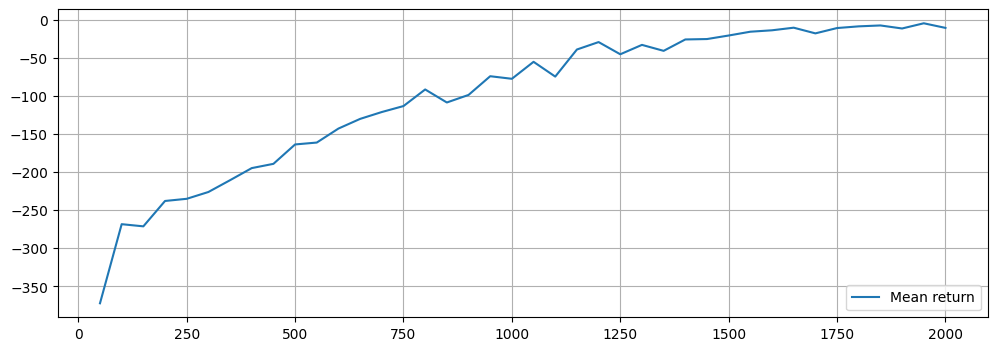

Episode: 2000, Return: -14, AvgReturn[50]: -10


In [ ]:
seed = 1337
taxi_env = TaxiMDPWrapper()
agent = DynaQAgent(
    len(taxi_env.states), len(taxi_env.actions), lr=0.05, gamma=0.975, eps=0.1, seed=seed,
    f_model=Model
)

log_q = train_stochastick_1(taxi_env, agent, n_episodes=2001, on_model_updates=0,
                          seed=seed, show_progress_schedule=50)

## со стохастикой такси и пассажира 0.01

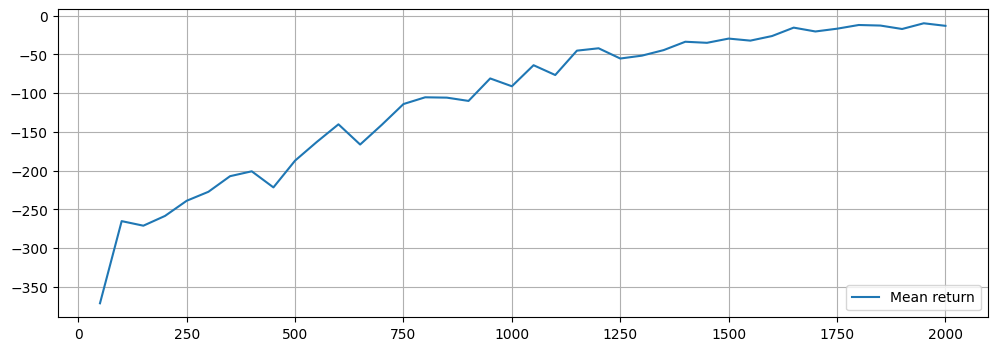

Episode: 2000, Return: -39, AvgReturn[50]: -13


In [ ]:
seed = 1337
taxi_env = TaxiMDPWrapper()
agent = DynaQAgent(
    len(taxi_env.states), len(taxi_env.actions), lr=0.05, gamma=0.975, eps=0.1, seed=seed,
    f_model=Model
)

log_q_stt_001_stp_001 = train_stochastick_1(taxi_env, agent,
                                   stoch_t = 0.01,
                                   stoch_p = 0.01,
                                   n_episodes=2001,
                                   on_model_updates=0,
                                   seed=seed,
                                   show_progress_schedule=50)

## со стохастикой такси  0.01 и пассажира 0.1

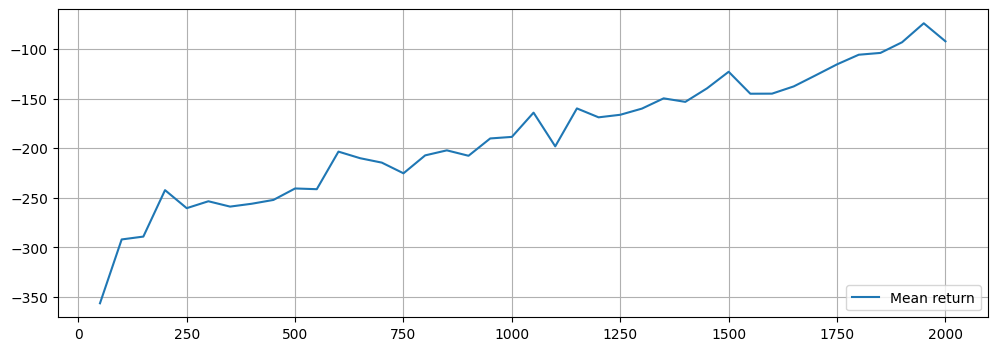

Episode: 2000, Return: -7, AvgReturn[50]: -92


In [ ]:
seed = 1337
taxi_env = TaxiMDPWrapper()
agent = DynaQAgent(
    len(taxi_env.states), len(taxi_env.actions), lr=0.05, gamma=0.975, eps=0.1, seed=seed,
    f_model=Model
)

log_q_stt_001_stp_01 = train_stochastick_1(taxi_env, agent,
                                   stoch_t = 0.01,
                                   stoch_p = 0.1,
                                   n_episodes=2001,
                                   on_model_updates=0,
                                   seed=seed,
                                   show_progress_schedule=50)

## со стохастикой такси  0.1 и пассажира 0.01

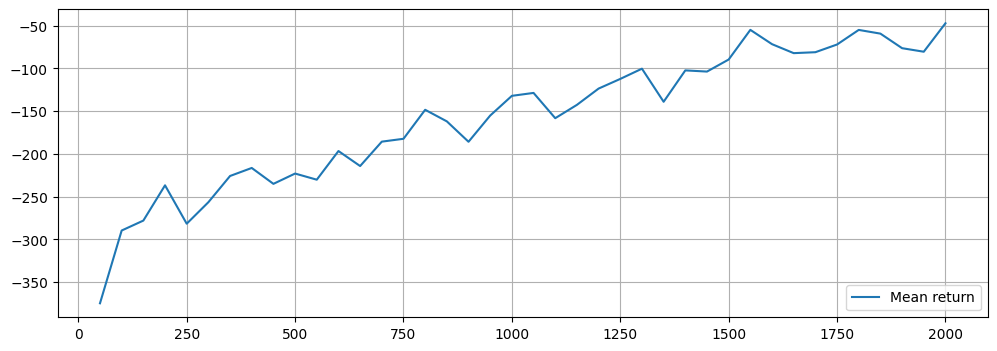

Episode: 2000, Return: -32, AvgReturn[50]: -47


In [ ]:
seed = 1337
taxi_env = TaxiMDPWrapper()
agent = DynaQAgent(
    len(taxi_env.states), len(taxi_env.actions), lr=0.05, gamma=0.975, eps=0.1, seed=seed,
    f_model=Model
)

log_q_stt_01_stp_001 = train_stochastick_1(taxi_env, agent,
                                   stoch_t = 0.1,
                                   stoch_p = 0.01,
                                   n_episodes=2001,
                                   on_model_updates=0,
                                   seed=seed,
                                   show_progress_schedule=50)

# Dyna-Q with imperfect model

In [ ]:
class ImperfectModel(Model):
    """
    Давайте теперь представим, что мы не знаем ничего о среде (например,
    что она детерминированная), и будем учить переходы  α -обучением,
    то есть с некоторым learning rate'ом.
    """

    def __init__(self, n_states, n_actions, lr: float, seed: int):
        super().__init__(n_states, n_actions, seed)
        # переход (s, a) -> next_s обучается со скоростью `lr`
        self.lr = lr
        self.mask_state_action = np.zeros((n_states, n_actions), dtype=float)


    def add(self, s: int, a: int, r: float, next_s: int) -> float:
        # переход (s, a) -> next_s обучается со скоростью `lr`
        # для простоты функцию вознаграждения обучаем мгновенно
        self.r[next_s] = r
        self.next_s[s][a] = next_s
        self.mask_state[s] += 1
        self.mask_state_action[s][a] += self.lr * (1 - self.mask_state_action[s][a])
        return r

    def predict_transition(self, s, a):
        # неидеальное предсказание модели перехода: чем менее изучен переход (s, a) -> next_s,
        # тем выше вероятность случайного предсказания.
        anomaly_prob = 1 - self.mask_state_action[s][a]
        if self._rng.random() < anomaly_prob:
            next_s = self._rng.choice(self.mask_state.size)
        else:
            next_s = self.next_s[s][a]
        return self.r[s, a], next_s

## со стохастикой такси и пассажира 0.01

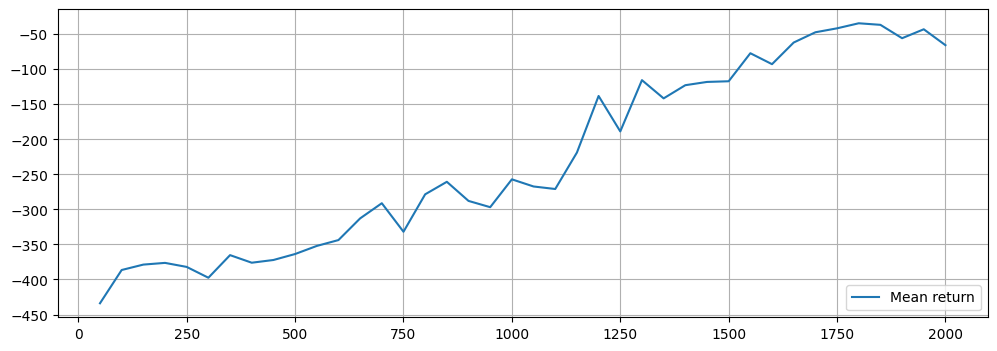

Episode: 2000, Return: -3, AvgReturn[50]: -66


In [ ]:
seed = 1337
taxi_env = TaxiMDPWrapper()
agent = DynaQAgent(
    len(taxi_env.states), len(taxi_env.actions), lr=0.05, gamma=0.975, eps=0.1, seed=seed,
    f_model=partial(ImperfectModel, lr=0.1)
)

log_dyna_q_imp_stt_001_stp_001 = train_stochastick_1(taxi_env, agent,
                                                    stoch_t = 0.01,
                                                    stoch_p = 0.01,
                                                    n_episodes=2001,
                                                    on_model_updates=10,
                                                    seed=seed)

## со стохастикой такси  0.01 и пассажира 0.1

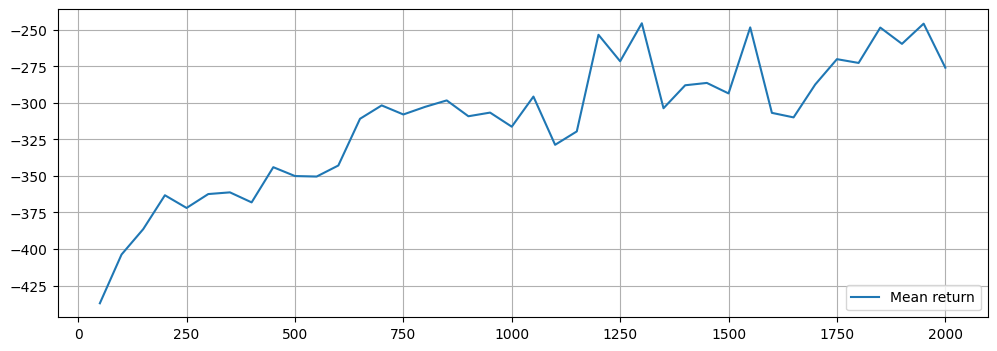

Episode: 2000, Return: -88, AvgReturn[50]: -276


In [ ]:
seed = 1337
taxi_env = TaxiMDPWrapper()
agent = DynaQAgent(
    len(taxi_env.states), len(taxi_env.actions), lr=0.05, gamma=0.975, eps=0.1, seed=seed,
    f_model=partial(ImperfectModel, lr=0.1)
)

log_dyna_q_imp_stt_001_stp_01 = train_stochastick_1(taxi_env, agent,
                                                    stoch_t = 0.01,
                                                    stoch_p = 0.1,
                                                    n_episodes=2001,
                                                    on_model_updates=10,
                                                    seed=seed)

# DynaQDreamerAgent
 **with imperfect model**

In [ ]:
class DynaQDreamerAgent(DynaQAgent):
    def dream(self, max_steps, state):
        # стартовое для траектории длины max_steps в воображении
        s = state
        for _ in range(max_steps):
            # последовательный шаг в воображении
            a = self.act(s)
            r, next_s = self.model.predict_transition(s, a)
            self.update(s, a, r, next_s, update_model=False)
            s = next_s

In [ ]:
class IntrinsicMotivationModel(ImperfectModel):
    def __init__(self, n_states, n_actions, lr: float, seed: int, add_intrinsic: float=0.):
        super().__init__(n_states, n_actions, lr, seed)
        self.add_intrinsic = add_intrinsic

    def add(self, s: int, a: int, r: float, next_s: int) -> float:
        # вычислите значение сигнала внутренней мотивации r_im
        # можете адаптировать код ниже. Здесь предлагается добавлять его только в случае, если переход
        # почти совсем не выучен, т.е. находится между 0. и learned_threshold
        learned_threshold = 0.25
        if self.add_intrinsic > 0. and self.mask_state_action[s][a] < learned_threshold:
            ####### Здесь ваш код ########
            r_im = 1 - self.mask_state_action[s][a]**2
            ##############################
            r += self.add_intrinsic * r_im
        return super().add(s, a, r, next_s)

## со стохастикой такси и пассажира 0.01

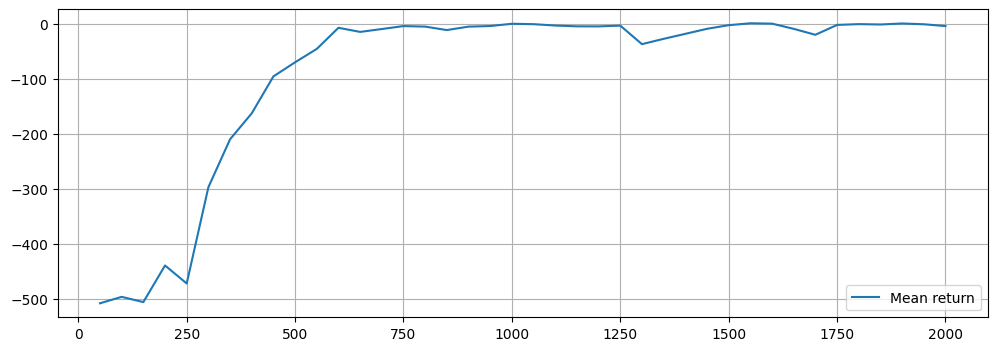

Episode: 2000, Return: -12, AvgReturn[50]: -4


In [ ]:
seed = 1337
taxi_env = TaxiMDPWrapper()
agent = DynaQDreamerAgent(
    len(taxi_env.states), len(taxi_env.actions), lr=0.05, gamma=0.975, eps=0.1, seed=seed,
    f_model=partial(IntrinsicMotivationModel, lr=0.1, add_intrinsic=0.)
)

log_dyna_q_imp_im_dreamer_stt_001_stp_001 = train_stochastick_1(
    taxi_env, agent,
    stoch_t = 0.01,
    stoch_p = 0.01,
    n_episodes=2001,
    on_model_updates=10,
    seed=seed
    )

## со стохастикой такси  0.01 и пассажира 0.1

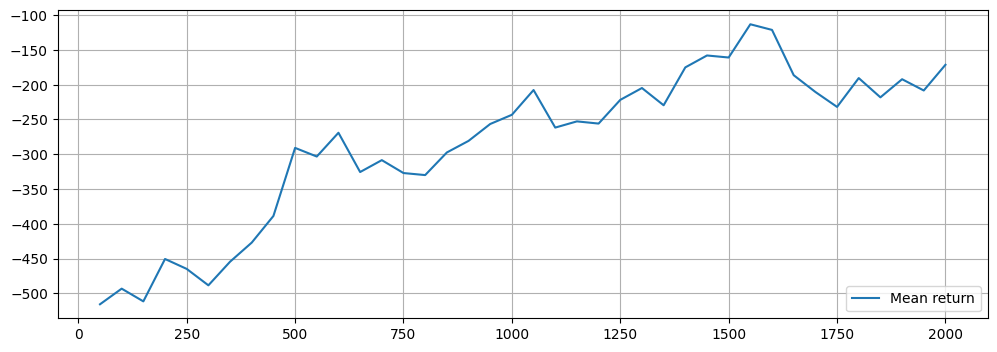

Episode: 2000, Return: -37, AvgReturn[50]: -171


In [ ]:
seed = 1337
taxi_env = TaxiMDPWrapper()
agent = DynaQDreamerAgent(
    len(taxi_env.states), len(taxi_env.actions), lr=0.05, gamma=0.975, eps=0.1, seed=seed,
    f_model=partial(IntrinsicMotivationModel, lr=0.1, add_intrinsic=0.)
)

log_dyna_q_imp_im_dreamer_stt_001_stp_01 = train_stochastick_1(
    taxi_env, agent,
    stoch_t = 0.01,
    stoch_p = 0.1,
    n_episodes=2001,
    on_model_updates=10,
    seed=seed
    )


## со стохастикой такси  0.1 и пассажира 0.01

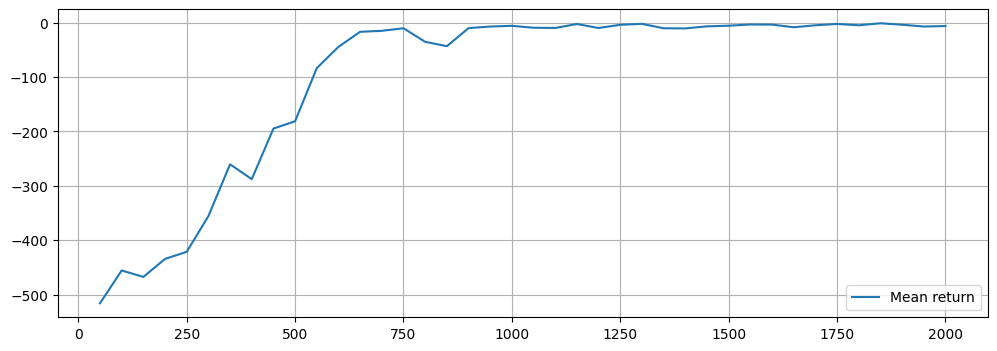

Episode: 2000, Return: -8, AvgReturn[50]: -7


In [ ]:
seed = 1337
taxi_env = TaxiMDPWrapper()
agent = DynaQDreamerAgent(
    len(taxi_env.states), len(taxi_env.actions), lr=0.05, gamma=0.975, eps=0.1, seed=seed,
    f_model=partial(IntrinsicMotivationModel, lr=0.1, add_intrinsic=0.)
)

log_dyna_q_imp_im_dreamer_stt_01_stp_001 = train_stochastick_1(
    taxi_env, agent,
    stoch_t = 0.1,
    stoch_p = 0.01,
    n_episodes=2001,
    on_model_updates=10,
    seed=seed
    )


# Сводный график

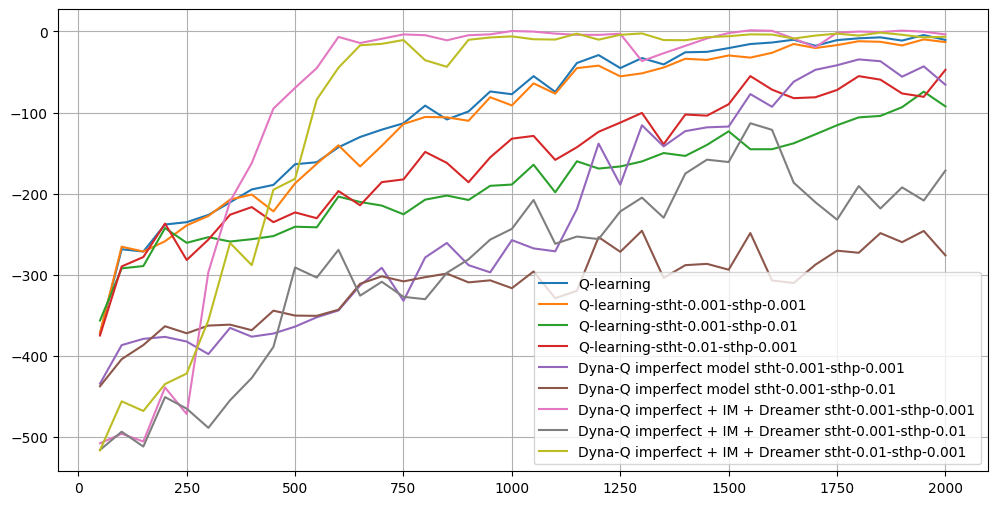

In [ ]:
compare_logs([
    (log_q, 'Q-learning'),
    (log_q_stt_001_stp_001, 'Q-learning-stht-0.001-sthp-0.001'),
    (log_q_stt_001_stp_01, 'Q-learning-stht-0.001-sthp-0.01'),
    (log_q_stt_01_stp_001, 'Q-learning-stht-0.01-sthp-0.001'),
    (log_dyna_q_imp_stt_001_stp_001, 'Dyna-Q imperfect model stht-0.001-sthp-0.001'),
    (log_dyna_q_imp_stt_001_stp_01, 'Dyna-Q imperfect model stht-0.001-sthp-0.01'),
    (log_dyna_q_imp_im_dreamer_stt_001_stp_001, 'Dyna-Q imperfect + IM + Dreamer stht-0.001-sthp-0.001'),
    (log_dyna_q_imp_im_dreamer_stt_001_stp_01, 'Dyna-Q imperfect + IM + Dreamer stht-0.001-sthp-0.01'),
    (log_dyna_q_imp_im_dreamer_stt_01_stp_001, 'Dyna-Q imperfect + IM + Dreamer stht-0.01-sthp-0.001'),
])